In [1]:
import numpy as np
import scipy.integrate as integrate

import requests
import json
import base64

from astroquery.jplhorizons import Horizons

import plotly.graph_objects as go

In [13]:
obj = Horizons(id='399', location='500@10', epochs={"start": "2023-04-10", "stop": "2023-05-10", "step": "5"})
print(obj)
print(obj.ephemerides())

JPLHorizons instance "399"; location=500@10, epochs={'start': '2023-04-10', 'stop': '2023-05-10', 'step': '5'}, id_type=None
 targetname       datetime_str       datetime_jd ... alpha_true  PABLon  PABLat
    ---               ---                 d      ...    deg       deg     deg  
----------- ------------------------ ----------- ... ---------- -------- ------
Earth (399) 2023-Apr-10 00:00:00.000   2460044.5 ...     0.0057 199.5424 0.0014
Earth (399) 2023-Apr-16 00:00:00.000   2460050.5 ...     0.0057 205.4265 0.0017
Earth (399) 2023-Apr-22 00:00:00.000   2460056.5 ...     0.0057 211.2931 0.0018
Earth (399) 2023-Apr-28 00:00:00.000   2460062.5 ...     0.0057 217.1398 0.0019
Earth (399) 2023-May-04 00:00:00.000   2460068.5 ...     0.0056 222.9658 0.0022
Earth (399) 2023-May-10 00:00:00.000   2460074.5 ...     0.0056 228.7738 0.0026


In [10]:
## Useful constants
G = 6.67428e-11
m_earth = 5.97219e24
m_sun = 1.9891e30
au = 149597870700 # 1 Astronomical unit in meters
seconds_in_year = 1*365*24*60*60

earth_linear_vel = 2 * np.pi * au / seconds_in_year

# TODOs:
#### Core simulation:
- [ ] 3D
- [ ] Add 2nd planet
- [ ] Add all planets
- [ ] Add asteroid
#### Validation:
- [ ] Pull data from horizons
- [ ] Create an asteroid based on a past horizons timestamp/frame
- [ ] Create metrics to compare a single asteroid prediction

In [42]:
## Two-body problem

earth_pos_0 = np.array([au, 0])
earth_vel_0 = np.array([0, earth_linear_vel])

y_0 = np.concatenate([earth_pos_0, earth_vel_0])

def sun_earth_diffeq(t, y):
    dy = np.zeros(y.shape)

    earth_to_sun = -y[0:2]
    r_earth_to_sun = np.linalg.norm(earth_to_sun)
    earth_to_sun = earth_to_sun / r_earth_to_sun
    
    force_sun_to_earth = G * m_sun * m_earth / (r_earth_to_sun**2)
    
    dy[0:2] = y[2:4]
    dy[2:4] = earth_to_sun * force_sun_to_earth / m_earth
    
    return dy

tspan = [0, seconds_in_year]
n_points = 100
t_eval = np.linspace(tspan[0], tspan[1], n_points)

soln_earth_sun = integrate.solve_ivp(sun_earth_diffeq, tspan, y_0, t_eval=t_eval)

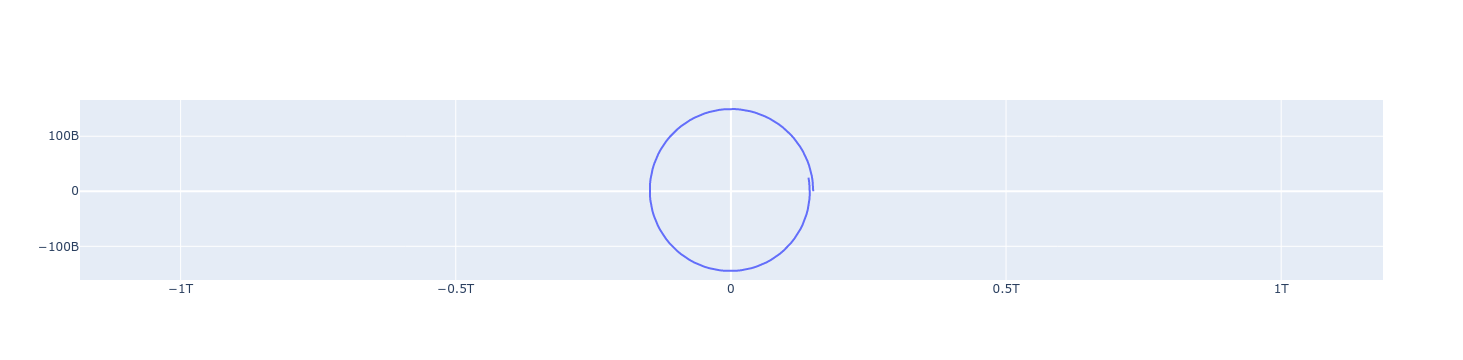

In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=soln_earth_sun.y[0, :],
    y=soln_earth_sun.y[1, :],
))

fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()